# Part 2. Model Training & Evaluation - RNN   
Now with the pretrained word embeddings acquired from Part 1 and the dataset acquired from
Part 0, you need to train a deep learning model for sentiment classification using the training set,
conforming to these requirements:


• Use the pretrained word embeddings from Part 1 as inputs; do not update them during training
(they are “frozen”).   

• Design a simple recurrent neural network (RNN), taking the input word embeddings, and
predicting a sentiment label for each sentence. To do that, you need to consider how to
aggregate the word representations to represent a sentence.   

• Use the validation set to gauge the performance of the model for each epoch during training.
You are required to use accuracy as the performance metric during validation and evaluation. 
   
• Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g.,
SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and
mini-batch size. (You should use the validation set to determine the optimal configuration.)
Train the model until the accuracy score on the validation set is not increasing for a few
epochs.
   
• Evaluate your trained model on the test dataset, observing the accuracy score.

## Setup Environment

In [1]:
import json
# We omit warnings to keep the output clean
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt 
import nltk

from common_utils import load_glove_embeddings, set_seed, EmbeddingMatrix, EarlyStopper, EmbeddingsDataset

In [2]:
# set seed 
set_seed()

# initialize parameters
BATCH_SIZE = 32
INPUT_SIZE = 100 # word embedding size 
HIDDEN_SIZE = 128 # just as a starter to see 
NUM_EPOCHS = 100 
EMBEDDING_DIM=100
GRADIENT_CLIP=5

In [3]:
# load dataset from huggingface first 
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

with open('result/word2idx.json', "r") as file:
    word2idx = json.load(file)

Let's add the padding token to the word embeddings.

In [4]:
# initialize word embeddings
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()

print("The index of <PAD> is: ", word_embeddings.pad_idx)

print(word_embeddings.to_tensor[word_embeddings.pad_idx])

The index of <PAD> is:  16163
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [5]:
def pad_collate(batch, pad_value):
    (xx, yy) = zip(*batch)
    # convert xx to a tensor
    xx = [torch.tensor(x, dtype=torch.int64) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    return xx_pad, torch.tensor(yy, dtype=torch.long)

### Datasets and Dataloaders

As we are performing mini-batch processing, at each batch, the length of sequence of each input has to be the same. To tackle the issue of different sequence lengths, we used <PAD> token.

Here, we create the datasets and dataloaders for the training, validation, and test sets. We also use the `pad_collate` function to pad the sequences in each batch.

Noted that we have a sorted version of the dataset as well. We use it to explore if a sorted dataset helps with our training. This will be elaborated later.

In [6]:
train_dataset_ed = EmbeddingsDataset(
    train_dataset["text"], train_dataset["label"],
    word_embeddings=word_embeddings
)
validation_dataset_ed = EmbeddingsDataset(
    validation_dataset["text"], validation_dataset["label"],
    word_embeddings=word_embeddings
)
test_dataset_ed = EmbeddingsDataset(test_dataset["text"], test_dataset["label"],
    word_embeddings=word_embeddings)

pad_value = word_embeddings.pad_idx
# implement minibatch training
train_dataloader = DataLoader(
    train_dataset_ed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
validation_dataloader = DataLoader(
    validation_dataset_ed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
test_dataloader = DataLoader(
    test_dataset_ed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)

AttributeError: 'EmbeddingMatrix' object has no attribute 'unk_idx'

In [ ]:
train_dataset_ed_sorted = EmbeddingsDataset(
    train_dataset["text"], train_dataset["label"],
    word_embeddings=word_embeddings,
    sort=True,
)
validation_dataset_ed_sorted = EmbeddingsDataset(
    validation_dataset["text"], validation_dataset["label"],
    word_embeddings=word_embeddings,
    sort=True,
)
test_dataset_ed_sorted = EmbeddingsDataset(test_dataset["text"], test_dataset["label"],
    word_embeddings=word_embeddings)

pad_value = word_embeddings.pad_idx
# implement minibatch training
train_dataloader_sorted = DataLoader(
    train_dataset_ed_sorted,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
validation_dataloader_sorted = DataLoader(
    validation_dataset_ed_sorted,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
test_dataloader_sorted = DataLoader(
    test_dataset_ed_sorted,
    batch_size=BATCH_SIZE,
    shuffle=True, # Note that we shuffle the test set, hence the test set is actually not sorted and random.
    collate_fn=lambda x: pad_collate(x, pad_value),
)

In [10]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [11]:
def train_loop_bce(train_dataloader, model, loss_fn, optimizer):
    if train_on_gpu:
        model.cuda()
    model.train()
    num_batches = len(train_dataloader)
    size = len(train_dataloader.dataset)
    train_loss, train_correct = 0, 0
    for batch_no, (X_batch, y_batch) in enumerate(train_dataloader):
        if train_on_gpu:
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
        # if want, can do some shuffling here 
        # Forward pass
        pred = model(X_batch)
        
        pred = pred.squeeze(1)
        pred_binary = (pred >= 0.5).long()
        loss = loss_fn(pred, y_batch.float())
        train_loss += loss.item() 
        train_correct += (pred_binary==y_batch.long()).sum().item() 
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # TODO add main branch
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)
        
        optimizer.step()
    
    train_loss /= num_batches 
    train_correct /= size 

    return train_loss, train_correct 
   

def test_loop_bce(validate_dataloader, model, loss_fn):
    if train_on_gpu:
        model.cuda()
    model.eval()
    num_batches = len(validate_dataloader)
    size = len(validate_dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in validate_dataloader:
            if train_on_gpu:
                X_batch = X_batch.cuda()
                y_batch = y_batch.cuda()

            pred = model(X_batch)
            pred = pred.squeeze(1)
            pred_binary = (pred >= 0.5).long()
            test_loss += loss_fn(pred, y_batch.float()).item()
            test_correct += (pred_binary == y_batch.long()).sum().item()

    test_loss /= num_batches
    test_correct /= size
    return test_loss, test_correct

def test_performance(test_dataloader, model):
    if train_on_gpu:
        model.cuda()
    model.eval()
    size = len(test_dataloader.dataset)
    test_correct = 0

    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            if train_on_gpu:
                X_batch = X_batch.cuda()
                y_batch = y_batch.cuda()

            pred = model(X_batch)
            pred = pred.squeeze(1)
            pred_binary = (pred >= 0.5).long()
            test_correct += (pred_binary == y_batch.long()).sum().item()
    
    test_correct /= size
    return test_correct

### Training Function with & without Early Stop

We have two seperate train function, `train` and `train_early_stop`.

`train_early_stop` utilise early stopping, a standard practice to prevent overfitting. The early stopping algorithm has a default patience of 3, so the training of the model stops if the validation loss does not decrease after 3 epochs. 


In [12]:
def train(model, optim, criterion, training_dataloader, validation_dataloader, epoch = NUM_EPOCHS):
  validation_acc = [] 
  train_acc = []
  train_losses, validate_losses = [], []
  for i in range(epoch):
    train_loss, train_correct = train_loop_bce(training_dataloader, model, criterion, optim) 
    validate_loss, validate_correct = test_loop_bce(validation_dataloader, model, criterion)
    validation_acc.append(validate_correct)
    train_acc.append(train_correct)
    train_losses.append(train_loss)
    validate_losses.append(validate_loss)

    print(f"Epoch {i+1}, Train Loss: {train_loss:.4f}, Validate Loss: {validate_loss:.4f}")
    #if i%10 == 0:
    print(f"Epoch:{i+1} \t Train Acc:{train_correct} \t Validation Acc:{validate_correct}")
  return train_acc, validation_acc, train_losses, validate_losses

In [13]:
def train_early_stop(model, optim, criterion, training_dataloader, validation_dataloader, clipping = True, patience = 3):
  validation_acc = [] 
  train_acc = []
  train_losses, validate_losses = [], []
  early_stopper = EarlyStopper(patience=patience)
  i = 0
  while True:
    train_loss, train_correct = train_loop_bce(training_dataloader, model, criterion, optim, clipping) 
    validate_loss, validate_correct = test_loop_bce(validation_dataloader, model, criterion)
    validation_acc.append(validate_correct)
    train_acc.append(train_correct)
    train_losses.append(train_loss)
    validate_losses.append(validate_loss)

    print(f"Epoch {i+1}, Train Loss: {train_loss:.4f}, Validate Loss: {validate_loss:.4f}")
    #if i%10 == 0:
    print(f"Epoch:{i+1} \t Train Acc:{train_correct} \t Validation Acc:{validate_correct}")
    if early_stopper.early_stop(validate_loss):
        print("Early stopping")
        break
    i += 1
  return train_acc, validation_acc, train_losses, validate_losses

In [14]:
def plot(a: dict, x_label = "", y_label = "", title = ""):
    for key in a:
        plt.plot(a[key], label=key)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

# Exploration

### Base RNN Model

Our base vanilla RNN will use the last hidden state (hn(w)) at the last step and then pass it as an input into the Fully Connected (FC) layer.

In [15]:
# using nn.Embeddings 
class VanillaRNNLastHidden(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,  embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(VanillaRNNLastHidden, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, hidden = self.rnn(x, h0)
        # Max pooling
        #out, _ = torch.max(out, dim=1)
        # Only take the last output for each sequence
        res = hidden[-1]
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)
        
        return res


### Fixed Length or Variable Length

To pad the sentence, we can either 
1. Fixed Length: set a fixed length for all the sentences, pad the shorter sentences with 0s and truncate the longer sentences, or
2. Variable Length: pad the entire sentences dynamically during batching using `torch,nn.utils.rnn.pad_sequence`. The second method is declared above.

#### Fixed Length

In [16]:
# initialize word embeddings
_word_embeddings = load_glove_embeddings()

_embeddings = [_word_embeddings[word] for word in _word_embeddings.keys()]

embedding_matrix_no_mask = np.array(_embeddings)
embedding_matrix_no_mask = np.vstack((embedding_matrix_no_mask, np.zeros((1, 100)))) # add a row of zeros for padding

print(embedding_matrix_no_mask.shape)

Loading GloVe embeddings...


Repo card metadata block was not found. Setting CardData to empty.


Total GloVe words loaded: 400000
(400001, 100)


In [17]:
# TODO: change the num_tokens 
class FixedLengthEmbeddingsDataset(Dataset):
  def __init__(self, X, y, num_tokens_per_sentence=25, word_embeddings=_word_embeddings):
    self.num_tokens_per_sentence = num_tokens_per_sentence
    self.word_embeddings = word_embeddings
    self.X = X # train_dataset['text']
    self.y = y # train_dataset['label']
    self.len = len(self.X)

  def __getitem__(self, index):
    # tokenize the sentence 
    tokens = self.tokenize_sentence(self.X[index])
    # convert each token to embeddings 
    sentence_tensor = self.convert_sentence_into_indices(tokens)
    label = torch.tensor(self.y[index], dtype=torch.long)
    return sentence_tensor, label 

  def __len__(self):
    return self.len 

  def tokenize_sentence(self, x): 
    '''
    returns a list containing the embeddings of each token 
    '''
    tokens = nltk.word_tokenize(x.lower())
    return tokens 
  
  def convert_sentence_into_indices(self, tokens):
    indices = []
    num_tokens_used = 0 
    for token in tokens:
      if num_tokens_used == self.num_tokens_per_sentence:
        break # we have enough of tokens from the sentence 
      if token in word2idx:
        indices.append(word2idx[token])
        num_tokens_used += 1 
    # # if not enough tokens in the sentence, use index of ?? 
    if len(indices) < self.num_tokens_per_sentence:
      padding = [(embedding_matrix_no_mask.shape[0] - 1 ) for _ in range(self.num_tokens_per_sentence - len(indices))]
      indices.extend(padding)
    #print(indices)
    indices = torch.tensor(indices, dtype=torch.long)
    return indices
  

In [18]:
no_mask_train_dataset_ed = FixedLengthEmbeddingsDataset(train_dataset['text'], train_dataset['label'])
no_mask_validation_dataset_ed = FixedLengthEmbeddingsDataset(validation_dataset['text'], validation_dataset['label'])
no_mask_test_dataset_ed = FixedLengthEmbeddingsDataset(test_dataset['text'], test_dataset['label'])

# implement minibatch training 
no_mask_train_dataloader = DataLoader(no_mask_train_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)
no_mask_validation_dataloader = DataLoader(no_mask_validation_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)
no_mask_test_dataloader = DataLoader(no_mask_test_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
vanilla_rnn = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=torch.tensor(embedding_matrix_no_mask, dtype=torch.float), padding_idx=embedding_matrix_no_mask.shape[0]-1)
optim = torch.optim.Adam(vanilla_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn_unmask, validation_acc_vanilla_rnn_unmask, train_loss_vanilla_rnn_unmask, validation_loss_vanilla_rnn_unmask = train(vanilla_rnn, optim, criterion, no_mask_train_dataloader, no_mask_validation_dataloader, epoch=50, clipping=False)

TypeError: train() got an unexpected keyword argument 'clipping'

Let us plot the training and validation accuracy without early stopping first to see how the model is performing.

In [ ]:
plot({"Train Acc": train_acc_vanilla_rnn_unmask, "Validation Acc": validation_acc_vanilla_rnn_unmask}, x_label="Epochs", y_label="Accuracy", title="Fixed Length Vanilla RNN Training and Validation Accuracy")
plot({"Train Loss": train_loss_vanilla_rnn_unmask, "Validation Loss": validation_loss_vanilla_rnn_unmask}, x_label="Epochs", y_label="Accuracy", title="Fixed Length Vanilla RNN Training and Validation Loss")

i = validation_loss_vanilla_rnn_unmask.index(min(validation_loss_vanilla_rnn_unmask))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn_unmask[i], "validation loss:", validation_loss_vanilla_rnn_unmask[i])

It seems the model overfits quite fast, let's try now with early stopping.

In [ ]:
vanilla_rnn = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=torch.tensor(embedding_matrix_no_mask, dtype=torch.float), padding_idx=embedding_matrix_no_mask.shape[0]-1)
optim = torch.optim.Adam(vanilla_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn, validation_acc_vanilla_rnn, train_loss_vanilla_rnn, validation_loss_vanilla_rnn = train_early_stop(vanilla_rnn, optim, criterion, no_mask_train_dataloader, no_mask_validation_dataloader, clipping=False)

In [ ]:
print("Current model performance with validation acc:", validation_acc_vanilla_rnn[-1], "validation loss:", validation_loss_vanilla_rnn[-1], "\n")

test_accuracy = test_performance(no_mask_test_dataloader, vanilla_rnn)
print("Fixed Length Vanilla RNN (last hidden state) Test accuracy:", test_accuracy)

#### Variable Length

In [ ]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn, validation_acc_vanilla_rnn, train_loss_vanilla_rnn, validation_loss_vanilla_rnn = train(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, epoch=50, clipping=False)

Let us plot the training and validation accuracy without early stopping first as well.

In [ ]:
plot({"Train Acc": train_acc_vanilla_rnn, "Validation Acc": validation_acc_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Variable Length Vanilla RNN Training and Validation Accuracy")
plot({"Train Loss": train_loss_vanilla_rnn, "Validation Loss": validation_loss_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Variable Length Vanilla RNN Training and Validation Loss")

i = validation_loss_vanilla_rnn.index(min(validation_loss_vanilla_rnn))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn[i], "validation loss:", validation_loss_vanilla_rnn[i])

Let's train with early stopping now!

In [ ]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# Since the model learns much slower, we increase the patience to 10
train_acc_vanilla_rnn, validation_acc_vanilla_rnn, train_loss_vanilla_rnn, validation_loss_vanilla_rnn = train_early_stop(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, clipping=False, patience=10)

In [ ]:
plot({"Train Acc": train_acc_vanilla_rnn, "Validation Acc": validation_acc_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Variable Length Vanilla RNN Training and Validation Accuracy (with Early Stop)")
plot({"Train Loss": train_loss_vanilla_rnn, "Validation Loss": validation_loss_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Variable Length Vanilla RNN Training and Validation Loss (with Early Stop)")

i = validation_loss_vanilla_rnn.index(min(validation_loss_vanilla_rnn))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn[i], "validation loss:", validation_loss_vanilla_rnn[i])

In [ ]:
print("Variable Length Vanilla RNN performance with validation acc:", validation_acc_vanilla_rnn[-1], "validation loss:", validation_loss_vanilla_rnn[-1], "\n")

test_accuracy = test_performance(test_dataloader, vanilla_rnn_hidden)
print("Variable Length Vanilla RNN (last hidden state) Test accuracy:", test_accuracy)

##### Some cool observation:

Notice if learning rate is higher than 0.0001 (e.g. >0.0002 here), the model will not converge.

In [ ]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0002)
criterion = nn.BCELoss()

train_acc_vanilla_rnn_high, validation_acc_vanilla_rnn_high, train_loss_vanilla_rnn_high, validation_loss_vanilla_rnn_high = train(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, epoch=50, clipping=False)

In [ ]:
plot({"Train Acc": train_acc_vanilla_rnn_high, "Validation Acc": validation_acc_vanilla_rnn_high}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN Training and Validation Accuracy (LR = 0.0002)")
plot({"Train Loss": train_loss_vanilla_rnn_high, "Validation Loss": validation_loss_vanilla_rnn_high}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN Training and Validation Loss (LR = 0.0002)")

i = validation_loss_vanilla_rnn_high.index(min(validation_loss_vanilla_rnn_high))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn_high[i], "validation loss:", validation_loss_vanilla_rnn_high[i])

### Gradient Clipping

We notice that there is a drastic changes during the training.

We decide to introduce gradient clipping to take a much smaller step when updating the gradient. 

With this, we can update the gradient much smoother and reduce the risk of overshooting during optimization. This helps the model converge more steadily, as shown below.

In [ ]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn_clip, validation_acc_vanilla_rnn_clip, train_loss_vanilla_rnn_clip, validation_loss_vanilla_rnn_clip = train(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, epoch=50, clipping=True)

In [ ]:
plot({"Train Acc": train_acc_vanilla_rnn_clip, "Validation Acc": validation_acc_vanilla_rnn_clip}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN Training and Validation Accuracy (with Gradient Clipping)")
plot({"Train Loss": train_loss_vanilla_rnn_clip, "Validation Loss": validation_loss_vanilla_rnn_clip}, x_label="Epochs", y_label="Accuracy", title="Masked Vanilla RNN Training and Validation Loss (with Gradient Clipping)")

i = validation_loss_vanilla_rnn_clip.index(min(validation_loss_vanilla_rnn_clip))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn_clip[i], "validation loss:", validation_loss_vanilla_rnn_clip[i])

We noticed that after implementing gradient clipping by norm and we achieved, although still steep, but at least a smaller step in the gradient update as shown below. This should hopefully prevent bad updates in our training.

Let's check if the test accuracy is improved.

In [ ]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# Since the model learns much slower, we increase the patience to 10
train_acc_vanilla_rnn_clip_2, validation_acc_vanilla_rnn_clip_2, train_loss_vanilla_rnn_clip_2, validation_loss_vanilla_rnn_clip_2 = train_early_stop(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, clipping=True, patience=10)

In [ ]:
print("Current Vanilla RNN (with Gradient Clipping) performance with validation acc:", validation_acc_vanilla_rnn_clip_2[-1], "validation loss:", validation_loss_vanilla_rnn_clip_2[-1], "\n")

test_accuracy = test_performance(test_dataloader, vanilla_rnn_hidden)
print("Vanilla RNN (with Gradient Clipping) Test accuracy:", test_accuracy)

We noticed the test accuracy is basically unchanged, as we now have 0.721 test accuracy while previously we had 0.738 test accuracy.

This indicates Gradient Clipping doesn't help much in improving accuracy in our scenario. However, it should still help with preventing bad updates.

### Sorted dataset input vs Unsorted dataset input

We tried sorting the dataset before training, and noticed we have a much smoother training curve. We believe this is since the model now can learn from the shortest sentence how to identify the key feature first before learning from the longer one.

In [ ]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn_sorted, validation_acc_vanilla_rnn_sorted, train_loss_vanilla_rnn_sorted, validation_loss_vanilla_rnn_sorted = train_early_stop(vanilla_rnn_hidden, optim, criterion, train_dataloader_sorted, validation_dataloader_sorted, clipping=True, patience=5)

In [ ]:
plot({"train acc": train_acc_vanilla_rnn_sorted, "validation acc": validation_acc_vanilla_rnn_sorted}, x_label="Epochs", y_label="Accuracy", title="Vanilla RNN Training and Validation Accuracy (Sorted Dataset)")
plot({"train loss": train_loss_vanilla_rnn_sorted, "validation loss": validation_loss_vanilla_rnn_sorted}, x_label="Epochs", y_label="Accuracy", title="Vanilla RNN Training and Validation Loss (Sorted Dataset)")

i = validation_loss_vanilla_rnn_sorted.index(min(validation_loss_vanilla_rnn_sorted))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn_sorted[i], "validation loss:", validation_loss_vanilla_rnn_sorted[i])

Let's see whether it improves the test accuracy!

In [ ]:
print("Current Vanilla RNN (with Sorted Dataset) performance with validation acc:", validation_acc_vanilla_rnn_sorted[-1], "validation loss:", validation_loss_vanilla_rnn_sorted[-1], "\n")

test_accuracy_sorted = test_performance(test_dataloader, vanilla_rnn_hidden)
print("Vanilla RNN (with Sorted Dataset) Test accuracy:", test_accuracy_sorted)

We noticed we have a much smoother training curve. We believe this is since the model now can learn from the shortest sentence how to identify the key feature first before learning from the longer one.

### Max pooling, Sum pooling and Avg Pooling

#### Last output RNN

In [ ]:
# using nn.Embeddings 
class LastOutputRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(LastOutputRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Get the last output for each sequence
        res = out[:, -1, :]
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res

Let's observe the model performance without early stopping!

In [ ]:
last_output_rnn = LastOutputRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(last_output_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_last_output, validation_acc_last_output, train_loss_last_output, validation_loss_last_output = train(last_output_rnn, optim, criterion, train_dataloader_sorted, validation_dataloader_sorted, epoch=50)

In [ ]:
plot({"Train Acc": train_acc_last_output, "Validation Acc": validation_acc_last_output}, x_label="Epochs", y_label="Accuracy", title="Last Output RNN Training and Validation Accuracy")
plot({"Train Loss": train_loss_last_output, "Validation Loss": validation_loss_last_output}, x_label="Epochs", y_label="Accuracy", title="Last Output RNN Training and Validation Loss")

i = validation_loss_last_output.index(min(validation_loss_last_output))
print("best performance (lowest validation loss) with validation acc:", validation_acc_last_output[i], "validation loss:", validation_loss_last_output[i])

With early stopping:

In [ ]:
last_output_rnn = LastOutputRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(last_output_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# Since the model learns much slower, we increase the patience to 10
train_acc_last_output, validation_acc_last_output, train_loss_last_output, validation_loss_last_output = train_early_stop(last_output_rnn, optim, criterion, train_dataloader_sorted, validation_dataloader_sorted, patience = 10)

In [ ]:
plot({"Train Acc": train_acc_last_output, "Validation Acc": validation_acc_last_output}, x_label="Epochs", y_label="Accuracy", title="Last Output RNN Training and Validation Accuracy (Early Stop)")
plot({"Train Loss": train_loss_last_output, "Validation Loss": validation_loss_last_output}, x_label="Epochs", y_label="Accuracy", title="Last Output RNN Training and Validation Loss (Early Stop)")

i = validation_loss_last_output.index(min(validation_loss_last_output))
print("best performance (lowest validation loss) with validation acc:", validation_acc_last_output[i], "validation loss:", validation_loss_last_output[i])

In [ ]:
print("Last Max Pooling RNN performance with validation acc:", validation_acc_last_output[-1], "validation loss:", validation_loss_last_output[-1], "\n")

test_accuracy_last_output = test_performance(test_dataloader_sorted, last_output_rnn)
print("Masked Max Pooling RNN Test accuracy:", test_accuracy_last_output)

We notice this is the same as passing the last hidden state to the FC layer.

After researching, we realize that the last hidden state is actually equivalent to the last output in `torch` implementation. This explains why their gradient grows the same way, and they also have similar validation accuracy and test accuracy.

![title](torch_RNN.png)

#### Max pooling RNN

In [ ]:
# using nn.Embeddings 
class MaxPoolRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(MaxPoolRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Max pooling
        # TODO: try with absolute
        res, _ = torch.max(out, dim=1)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res

In [ ]:
max_pool_rnn = MaxPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(max_pool_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_max, validation_acc_max, train_loss_max, validation_loss_max = train(max_pool_rnn, optim, criterion, train_dataloader_sorted, validation_dataloader_sorted, epoch=50)

In [ ]:
plot({"Train Acc": train_acc_max, "Validation Acc": validation_acc_max}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Accuracy")
plot({"Train Loss": train_loss_max, "Validation Loss": validation_loss_max}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Loss")

i = validation_loss_max.index(min(validation_loss_max))
print("best performance (lowest validation loss) with validation acc:", validation_acc_max[i], "validation loss:", validation_loss_max[i])

Let's see the performance with early stopping!

In [ ]:
max_pool_rnn = MaxPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(max_pool_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_max_early_stop, validation_acc_max_early_stop, train_loss_max_early_stop, validation_loss_max_early_stop = train_early_stop(max_pool_rnn, optim, criterion, train_dataloader_sorted, validation_dataloader_sorted)

In [ ]:
plot({"Train Acc": train_acc_max_early_stop, "Validation Acc": validation_acc_max_early_stop}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Accuracy (Early Stop)")
plot({"Train Loss": train_loss_max_early_stop, "Validation Loss": validation_loss_max_early_stop}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Loss (Early Stop)")

i = validation_loss_max_early_stop.index(min(validation_loss_max_early_stop))
print("best performance (lowest validation loss) with validation acc:", validation_acc_max_early_stop[i], "validation loss:", validation_loss_max_early_stop[i])

In [ ]:
print("Last Max Pooling RNN performance with validation acc:", validation_acc_max_early_stop[-1], "validation loss:", validation_loss_max_early_stop[-1], "\n")

test_accuracy_max_pool = test_performance(test_dataloader_sorted, max_pool_rnn)
print("Masked Max Pooling RNN Test accuracy:", test_accuracy_max_pool)

#### Sum Pooling RNN

In [ ]:
# using nn.Embeddings 
class SumPoolRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(SumPoolRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Sum pooling
        res = torch.sum(out, dim=1)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res

In [ ]:
sum_pool_rnn = SumPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(sum_pool_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_sum_rnn, validation_acc_sum_rnn, train_loss_sum_rnn, validation_loss_sum_rnn = train_early_stop(sum_pool_rnn, optim, criterion, train_dataloader_sorted, validation_dataloader_sorted, patience=5)

In [ ]:
plot({"Train Acc": train_acc_sum_rnn, "Validation Acc": validation_acc_sum_rnn}, x_label="Epochs", y_label="Accuracy", title="Sum Pooling RNN Training and Validation Accuracy (Early Stop)")
plot({"Train Loss": train_loss_sum_rnn, "Validation Loss": validation_loss_sum_rnn}, x_label="Epochs", y_label="Accuracy", title="Sum Pooling RNN Training and Validation Loss (Early Stop)")


i = validation_loss_sum_rnn.index(min(validation_loss_sum_rnn))
print("best performance (lowest validation loss) with validation acc:", validation_acc_sum_rnn[i], "validation loss:", validation_loss_sum_rnn[i])

In [ ]:
print("Last Sum Pooling RNN performance with validation acc:", validation_acc_sum_rnn[-1], "validation loss:", validation_loss_sum_rnn[-1], "\n")

test_accuracy_sum_pool = test_performance(test_dataloader_sorted, sum_pool_rnn)
print("Sum Pooling RNN Test accuracy:", test_accuracy_sum_pool)

#### Mean Pooling RNN

In [ ]:
class MeanPoolRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(MeanPoolRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Mean pooling
        res = torch.mean(out, dim=1)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res

In [ ]:
mean_pool_rnn = MeanPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(mean_pool_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_mean_rnn, validation_acc_mean_rnn, train_loss_mean_rnn, validation_loss_mean_rnn = train_early_stop(mean_pool_rnn, optim, criterion, train_dataloader_sorted, validation_dataloader_sorted, patience=5)

In [ ]:
plot({"Train Acc": train_acc_mean_rnn, "Validation Acc": validation_acc_mean_rnn}, x_label="Epochs", y_label="Accuracy", title="Mean Pooling RNN Training and Validation Accuracy (Early Stop)")
plot({"Train Loss": train_loss_mean_rnn, "Validation Loss": validation_loss_mean_rnn}, x_label="Epochs", y_label="Accuracy", title="Mean Pooling RNN Training and Validation Loss (Early Stop)")

i = validation_acc_mean_rnn.index(max(validation_acc_mean_rnn))
print("best performance (lowest validation loss) with validation acc:", max(validation_acc_mean_rnn), "validation loss:", validation_loss_mean_rnn[i])

In [ ]:
print("Last Mean Pooling RNN performance with validation acc:", validation_acc_mean_rnn[-1], "validation loss:", validation_loss_mean_rnn[-1], "\n")

test_accuracy_mean_pool = test_performance(test_dataloader_sorted, mean_pool_rnn)
print("Mean Pooling RNN Test accuracy:", test_accuracy_mean_pool)

Let's collate the results of the different models and their performances.

In [ ]:
print("Vanilla RNN using hidden state", test_accuracy_sorted)
print("Vanilla RNN using last output", test_accuracy_last_output)
print("Vanilla RNN using max pooling", test_accuracy_max_pool)
print("Vanilla RNN using sum pooling", test_accuracy_sum_pool)
print("Vanilla RNN using mean pooling", test_accuracy_mean_pool)

The results show that max pooling achieves a better result than just passing the last layer, sum pooling and average pooling. This could be due to the fact that max pooling picks the most significant word of the sentences, that significantly determines the sentiment of the overall sentence. 

### Hyperparameter Search: Grid Search 

#### Define our final model

Based on our exploration, we will now formulate our final vanilla RNN that integrates all our findings and improvements found along the way. We will use 
* 2 layers of RNN
* Use pad_sequence to deal with paddings
* Max Pooling
* Sorted Dataset
* Dropout (0.3).
  
We added dropout here to reduce the chances of overfitting.

The graph below represents the structure of our final RNN model.

![title](vanilla_RNN_final.jpg)

In [ ]:
# using nn.Embeddings 
class FinalVanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,  embedding_matrix_torch:torch.tensor, padding_idx: int, drop_out=0.3):
        super(FinalVanillaRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.drop_out = nn.Dropout(drop_out)
        self.sigmoid = nn.Sigmoid()

 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Max pooling
        res, _ = torch.max(out, dim=1)
        # Only take the last output for each sequence
        res = self.drop_out(res)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)
        
        return res


In [19]:
# init searching configurations 
no_epochs = [100, 200, 300]
lrs = [0.0001, 0.001]
batch_sizes = [32, 64, 128, 256]
optimizers = [torch.optim.Adam, torch.optim.SGD]

# set fixed hyperparameters
hidden_size=128
num_layers=2 
dropout=0.3

In [20]:
import logging 
logging.basicConfig(
    filename='find_optimal_hyperparams_mask_max_sorted.log',       # Name of the log file
    level=logging.INFO,        # Set the logging level (INFO, DEBUG, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log message format
    datefmt='%Y-%m-%d %H:%M:%S'  # Date format in log messages
)

In [ ]:
from collections import defaultdict 
def find_optimal_model_1(no_epochs, lrs, optimizers, batch_sizes, dropout=dropout, hidden_size=hidden_size, num_layers=num_layers, pad_value = word_embeddings.pad_idx):
  """
    Finds optimal hyperparameters by grid search
  """
  # train_dataset_ed = EmbeddingsDataset(train_dataset['text'], train_dataset['label'])
  # validation_dataset_ed = EmbeddingsDataset(validation_dataset['text'], validation_dataset['label'])
  criterion = nn.BCELoss()
  results = defaultdict(list) # {[lr, batch_size, optimizer, no_epoch]: [train_loss, train_acc, validate_loss, validation_acc, min_validation_loss, early_stopped?]} 
  for lr in lrs: 
    for batch_size in batch_sizes: 
      # initialize train loader and validate loader for minibatch training 
      train_dataloader_sorted = DataLoader(
          train_dataset_ed_sorted,
          batch_size=batch_size,
          shuffle=False,
          collate_fn=lambda x: pad_collate(x, pad_value),
      )
      validation_dataloader_sorted = DataLoader(
          validation_dataset_ed_sorted,
          batch_size=batch_size,
          shuffle=False,
          collate_fn=lambda x: pad_collate(x, pad_value),
      )
      for optim_index, optimizer in enumerate(optimizers): 
        for no_epoch in no_epochs: # for each of the number of epochs configuration
          last_min_validate_acc = None # from the EarlyStopper, it keeps track of the last min validation accuracy,
          # this is different from last validate loss which is just from the validate testing step
          early_stopped = False 
          early_stopper = EarlyStopper()
          model = FinalVanillaRNN(input_size=EMBEDDING_DIM, hidden_size=hidden_size, num_layers=num_layers, num_classes=1, drop_out=dropout, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
          optim = optimizer(model.parameters(), lr=lr)  
          logging.info(f"MODEL CONFIGURATIONS: lr: {lr}, batch_size: {batch_size}, optimizer: {optim_index}, no_epoch: {no_epoch}")
          print(f"MODEL CONFIGURATIONS: lr: {lr}, batch_size: {batch_size}, optimizer: {optim_index}, no_epoch: {no_epoch}")
          for i in range(no_epoch): # train and validate for every epoch 
            # train loop 
            train_loss, train_acc = train_loop_bce(train_dataloader_sorted, model, criterion, optim)
            # validate loop 
            validate_loss, validate_acc = test_loop_bce(validation_dataloader_sorted, model, criterion)
            if early_stopper.early_stop(validate_loss):
              # when_early_stopped = no_epoch 
              # last_train_acc_in_epochs = train_acc 
              # last_validate_acc_in_epochs = validate_acc 
              last_min_validate_loss = early_stopper.get_last_min_validation_loss()
              
              logging.info(f"\n{lr, batch_size, optim_index, no_epoch}: Early Stopped at {i+1}th epoch \n") 
              logging.info(f"last_trained_acc: {train_acc}, last_validate_acc: {validate_acc}, last min validate acc: {last_min_validate_loss}")   
              logging.info(f"last_train_loss: {train_loss}, last_validate_loss:  {validate_loss}")
              logging.info("============================================")
              print(f"\n{lr, batch_size, optim_index, no_epoch}: Early Stopped at {i+1}th epoch \n") 
              print(f"last_trained_acc: {train_acc}, last_validate_acc: {validate_acc}, last min validate acc: {last_min_validate_loss}")   
              print(f"last_train_loss: {train_loss}, last_validate_loss:  {validate_loss}")
              print("============================================")
              results[f"[{lr}, {batch_size}, {optim_index}, {no_epoch}]"] = [train_loss, train_acc, validate_loss, validate_acc, last_min_validate_loss, True] 
              
              early_stopped = True
              break
          if not early_stopped:
            logging.info(f"\n{lr, batch_size, optim_index, no_epoch}:") 
            logging.info(f"last_trained_acc: {train_acc}, last_validate_acc: {validate_acc}")   
            logging.info(f"last_train_loss: {train_loss}, last_validate_loss:  {validate_loss}")
            logging.info("============================================")
            print(f"\n{lr, batch_size, optim_index, no_epoch}:") 
            print(f"last_trained_acc: {train_acc}, last_validate_acc: {validate_acc}")   
            print(f"last_train_loss: {train_loss}, last_validate_loss:  {validate_loss}")
            print("============================================")
            results[f"[{lr}, {batch_size}, {optim_index}, {no_epoch}]"] = [train_loss, train_acc, validate_loss, validate_acc, None, False]

  return results         

In [28]:
results = find_optimal_model_1(no_epochs=no_epochs, lrs=lrs, optimizers=optimizers, batch_sizes=batch_sizes)

MODEL CONFIGURATIONS: lr: 0.0001, batch_size: 32, optimizer: 0, no_epoch: 100

(0.0001, 32, 0, 100): Early Stopped at 33th epoch 

last_trained_acc: 0.7902696365767878, last_validate_acc: 0.7870544090056285, last min validate acc: 0.4793315740192638
last_train_loss: 0.4408021465446172, last_validate_loss:  0.48100464133655324
MODEL CONFIGURATIONS: lr: 0.0001, batch_size: 32, optimizer: 0, no_epoch: 200

(0.0001, 32, 0, 200): Early Stopped at 31th epoch 

last_trained_acc: 0.786400937866354, last_validate_acc: 0.7842401500938087, last min validate acc: 0.48243849330088673
last_train_loss: 0.4457346856705705, last_validate_loss:  0.48499320359791026
MODEL CONFIGURATIONS: lr: 0.0001, batch_size: 32, optimizer: 0, no_epoch: 300

(0.0001, 32, 0, 300): Early Stopped at 20th epoch 

last_trained_acc: 0.7607268464243845, last_validate_acc: 0.7654784240150094, last min validate acc: 0.49240278496461753
last_train_loss: 0.48040384790870583, last_validate_loss:  0.4928799964049283
MODEL CONFIGURA

In [29]:
import pickle 
pickle.dump(results, open("results_nicole_find_optimal_params_mask_max_sorted.pkl", "wb"))

In [30]:

sorted_results = sorted(results.items(), key=lambda x: x[1][3], reverse=True)

In [32]:
print(sorted_results[:10])

[('[0.0001, 32, 0, 100]', [0.4408021465446172, 0.7902696365767878, 0.48100464133655324, 0.7870544090056285, 0.4793315740192638, True]), ('[0.0001, 32, 0, 200]', [0.4457346856705705, 0.786400937866354, 0.48499320359791026, 0.7842401500938087, 0.48243849330088673, True]), ('[0.001, 32, 1, 200]', [0.49310367389787896, 0.7514654161781946, 0.4868718429523356, 0.7814258911819888, None, False]), ('[0.001, 32, 0, 200]', [0.3916850863547807, 0.8223915592028136, 0.49298853383344765, 0.774859287054409, 0.46971070634968143, True]), ('[0.001, 32, 1, 300]', [0.4800042880050252, 0.7647127784290738, 0.4900094007744509, 0.7720450281425891, 0.489680920891902, True]), ('[0.001, 32, 0, 100]', [0.4176817518494995, 0.8082063305978898, 0.4943951789070578, 0.7701688555347092, 0.479839324074633, True]), ('[0.001, 32, 0, 300]', [0.4464642052235228, 0.7878077373974208, 0.50504610117744, 0.7692307692307693, 0.49079450701966004, True]), ('[0.0001, 32, 0, 300]', [0.48040384790870583, 0.7607268464243845, 0.492879996

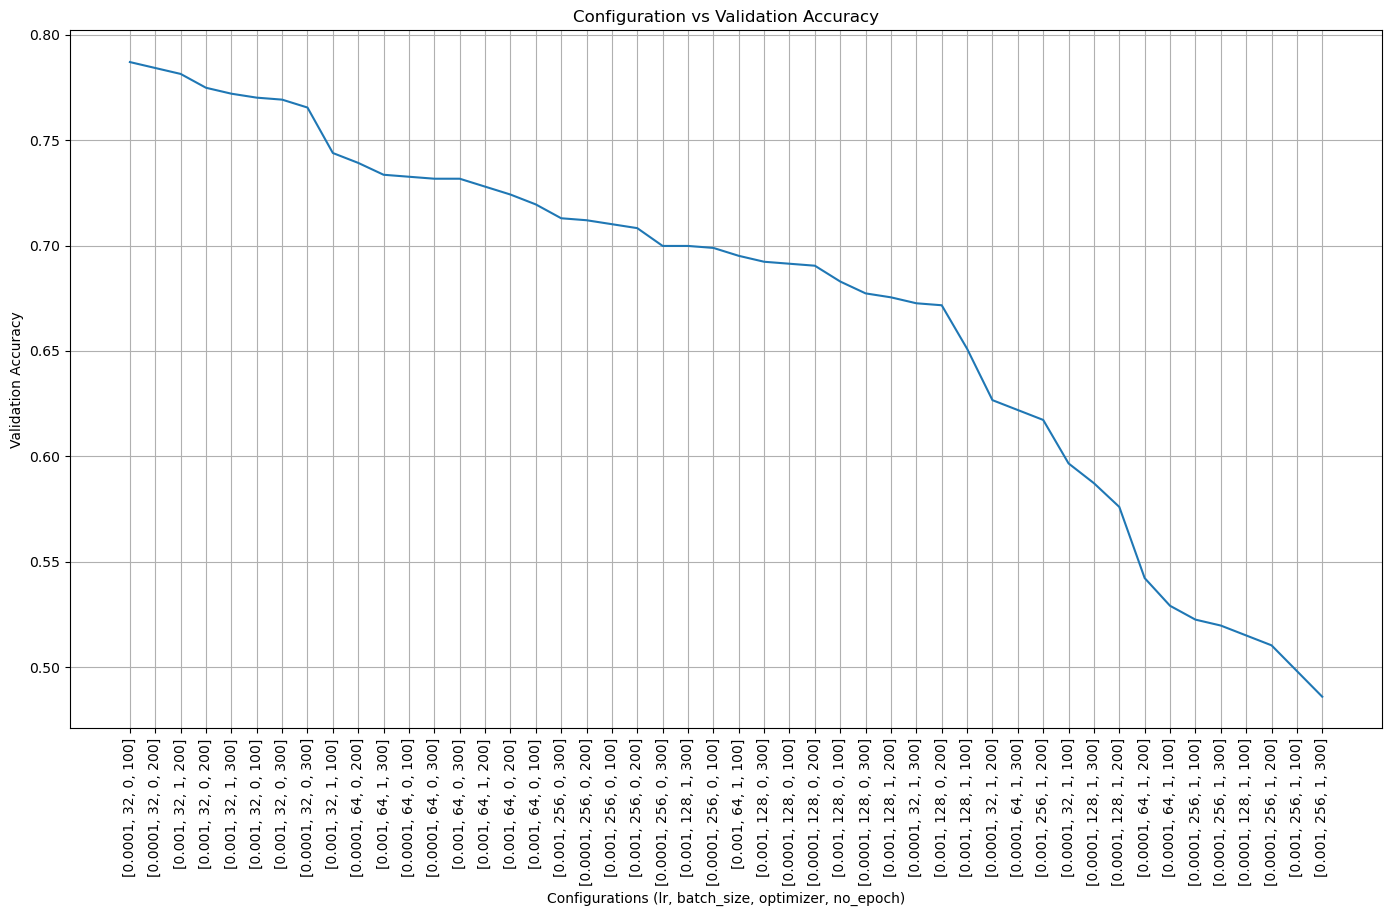

In [31]:
configs = [x[0] for x in sorted_results]
validate_accs = [x[1][3] for x in sorted_results]
plt.figure(figsize=(14,8))
plt.xticks(rotation=90)
plt.xlabel("Configurations (lr, batch_size, optimizer, no_epoch)")
plt.ylabel("Validation Accuracy")
plt.title("Configuration vs Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.plot(configs, validate_accs)


In [52]:
# train the best model 
best_lr = 0.0001
best_bs = 32 
best_optimizer = torch.optim.Adam
best_no_epoch = 100

# fixed parameters
hidden_size=128
num_layers=2 
dropout=0.3

train_dataloader_sorted = DataLoader(
          train_dataset_ed_sorted,
          batch_size=best_bs,
          shuffle=False,
          collate_fn=lambda x: pad_collate(x, pad_value),
      )



# # use an unsorted test dataset 
test_dataset_ed_sorted = EmbeddingsDataset(test_dataset["text"], test_dataset["label"], sort=True)
test_dataloader_unsorted = DataLoader(
    test_dataset_ed_sorted,
    batch_size=best_bs,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)



In [ ]:
# Test loop
# (0.0001, 32, 0, 100): Early Stopped at 33th epoch  

def train_optimal_model(best_bs=best_bs, best_lr=best_lr, best_no_epoch=best_no_epoch, best_optimizer=best_optimizer, dropout=0.3, num_layers=2, hidden_size=128):
    validation_accs = [] 
    validation_losses = [] 
    train_losses = [] 
    train_accs = [] 
    opt_model = FinalVanillaRNN(input_size=EMBEDDING_DIM, hidden_size=hidden_size, num_layers=num_layers, num_classes=1, drop_out=dropout, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
    criterion = nn.BCELoss()
    optim = best_optimizer(opt_model.parameters(), lr=best_lr)
    for i in range(33):
        train_loss, train_acc = train_loop_bce(train_dataloader_sorted, opt_model, criterion, optim)
        validate_loss, validate_acc = test_loop_bce(validation_dataloader_sorted, opt_model, criterion)
        validation_accs.append(validate_acc)
        validation_losses.append(validate_loss)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
    return opt_model, validation_accs, validation_losses, train_losses, train_accs

# using our best model   
optimal_model_RNN, validation_accs, validation_losses, train_losses, train_accs = train_optimal_model()
torch.save(optimal_model_RNN, "optimal_model_RNN")
test_acc = test_performance(test_dataloader_unsorted, optimal_model_RNN)

In [56]:
print("The test accuracy of the optimal model is: ", test_acc)

The test accuracy of the optimal model is:  0.8067542213883677


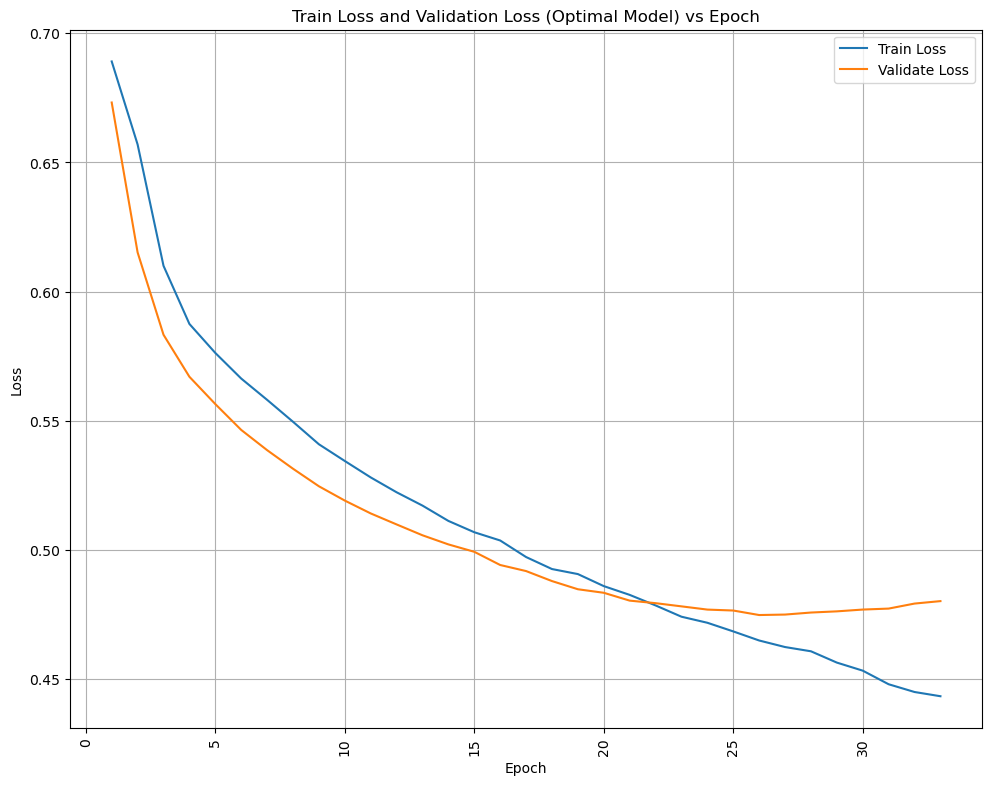

In [64]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss and Validation Loss (Optimal Model) vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.plot([i+1 for i in range(33)], train_losses, label="Train Loss")
plt.plot([i+1 for i in range(33)], validation_losses, label="Validate Loss")
plt.legend()

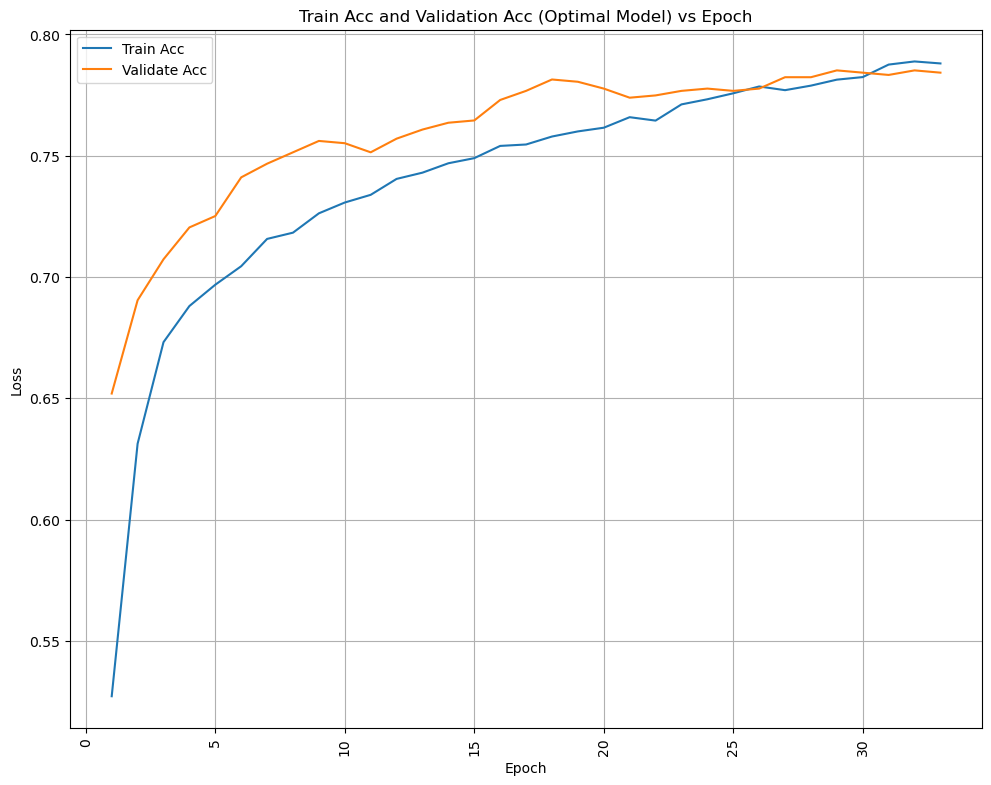

In [65]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Acc and Validation Acc (Optimal Model) vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.plot([i+1 for i in range(33)], train_accs, label="Train Acc")
plt.plot([i+1 for i in range(33)], validation_accs, label="Validate Acc")
plt.legend()

In [72]:
import pandas as pd

# Example data
epochs = list(range(1, 34))

# Creating a DataFrame
metrics_df = pd.DataFrame({
    "Epoch": epochs,
    "Train Loss": train_losses,
    "Validation Loss": validation_losses,
    "Train Accuracy": train_accs,
    "Validation Accuracy": validation_accs
})

# Display the DataFrame
metrics = metrics_df.reset_index(drop=True)
display(metrics)

,Epoch,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
0,1,0.689083,0.673196,0.527198,0.651970
1,2,0.656952,0.615189,0.631301,0.690432
2,3,0.610015,0.583338,0.673154,0.707317
3,4,0.587519,0.567078,0.688042,0.720450
4,5,0.576303,0.556518,0.696835,0.725141
5,6,0.566391,0.546513,0.704455,0.741088
6,7,0.558153,0.538687,0.715709,0.746717
7,8,0.549667,0.531499,0.718288,0.751407
8,9,0.540963,0.524709,0.726260,0.756098
9,10,0.534489,0.519171,0.730715,0.755159


In [73]:
metrics.to_csv("Part_2_validation_acc_opt_model.csv")

In [80]:
# test the optimal model 
optimal_model_RNN = torch.load("optimal_model_RNN")
test_acc = test_performance(test_dataloader_unsorted, optimal_model_RNN)
test_acc_sorted = test_performance(test_dataloader_sorted, optimal_model_RNN)

In [81]:
test_acc

0.8067542213883677

In [82]:
test_acc_sorted

0.8067542213883677